In [1]:
from collections import defaultdict, Counter
from dataclasses import dataclass, field
import logging
from typing import cast, Dict, List, Tuple, Union, Callable, Set
from typing_extensions import get_args, Literal
import sys
import os
import numpy as np
import random 
import seaborn as sns
from PIL import Image
import re
import itertools
import json

import torch
import torch.nn as nn
import torch.nn.functional as F

import yaml
import argparse
import pandas as pd
from tqdm.notebook import tqdm
from functools import partial
from torch.utils.data import DataLoader, TensorDataset

sys.path.append('/users/sanand14/data/sanand14/learning_dynamics/src/experiments/utils')
sys.path.append('/users/sanand14/data/sanand14/learning_dynamics/src/experiments')

from data_utils import (loadText, get_observation_class, 
                        load_conll_dataset, embedBertObservation, 
                        ObservationIterator, match_tokenized_to_untokenized)
from task import ParseDistanceTask, ParseDepthTask, CPosTask, FPosTask, DepTask, NerTask, PhrStartTask, PhrEndTask
from utils.forgetting_utils import AdamEF
from utils.toy_utils import bin_train_loop, bin_val_loop, create_dataloaders_bin, Probe, POSVocabGenerator
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
from transformers import BertConfig, BertModel, AdamW, BertTokenizer

[2024-04-20 14:14:41,753] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
home = os.environ["LEARNING_DYNAMICS_HOME"]
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
output_dir = os.path.join(home, 'outputs/icl_bert', 'seed_0')

In [4]:
multibert_dirs = [os.path.join(output_dir, d) for d in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, d)) and 'bert' in d]

In [29]:
multibert_dirs_seed1 = [dir.replace('seed_0', 'seed_1') for dir in multibert_dirs]
multibert_dirs_seed2 = [dir.replace('seed_0', 'seed_2') for dir in multibert_dirs]


In [5]:
def parse_metric(file_path, metric):
    with open(file_path, 'r') as file:
        content = file.read()
    content = content.replace("'", '"')
    try:
        data = json.loads(content)
        val_acc_epoch = data[metric]
        return val_acc_epoch
    except json.JSONDecodeError as e:
        print(f"An error occurred while parsing JSON: {e}")
        return None

In [30]:
def plot_metrics(layer, metrics, subtract_zero=False, log=False, multibert_dirs=multibert_dirs):
    values0 = {}    
    if isinstance(metrics, str):
        metrics = [metrics]
    for metric in metrics:
        for bert_dir in multibert_dirs:
            curr_layer = 'layer-' + str(0)
            curr_output_dir = os.path.join(bert_dir, curr_layer)
            curr_step = int(''.join(bert_dir.split('_')[-1])[:-1])
            
            values0[curr_step] = parse_metric(os.path.join(curr_output_dir, 'val_acc.txt'), metric)
            
        values = {}
        for bert_dir in multibert_dirs:
            curr_layer = 'layer-' + str(layer)
            curr_output_dir = os.path.join(bert_dir, curr_layer)
            curr_step = int(''.join(bert_dir.split('_')[-1])[:-1])
            
            values[curr_step] = parse_metric(os.path.join(curr_output_dir, 'val_acc.txt'), metric)
            if subtract_zero:
                values[curr_step] -= values0[curr_step]
        
        steps = sorted(values.keys())
        values = [values[step] for step in steps]
        plt.plot(steps, values)
    plt.title(f'{metrics} Test Accuracy {"after subtracting Layer 0" if subtract_zero else ""}')
    if log:
        plt.gca().set_xscale('log')
    plt.legend(metrics)
    plt.xlabel('Step in 1000s for MultiBERT')

In [31]:
def plot_metric(layers, metric, subtract_zero=False, log=False, multibert_dirs=multibert_dirs):
    values0 = {}
    for bert_dir in multibert_dirs:
        curr_layer = 'layer-' + str(0)
        curr_output_dir = os.path.join(bert_dir, curr_layer)
        curr_step = int(''.join(bert_dir.split('_')[-1])[:-1])
        
        values0[curr_step] = parse_metric(os.path.join(curr_output_dir, 'val_acc.txt'), metric)
        
    if isinstance(layers, int):
        layers = [layers]
    for layer in layers:
        values = {}
        for bert_dir in multibert_dirs:
            curr_layer = 'layer-' + str(layer)
            curr_output_dir = os.path.join(bert_dir, curr_layer)
            curr_step = int(''.join(bert_dir.split('_')[-1])[:-1])
            
            values[curr_step] = parse_metric(os.path.join(curr_output_dir, 'val_acc.txt'), metric)
            if subtract_zero:
                values[curr_step] -= values0[curr_step]
        
        steps = sorted(values.keys())
        values = [values[step] for step in steps]
        plt.plot(steps, values)
    plt.title(f'{metric} Test Accuracy {"after subtracting Layer 0" if subtract_zero else ""}')
    plt.legend(layers)
    if log:
        plt.gca().set_xscale('log')
    plt.xlabel('Step in 1000s for MultiBERT')

In [44]:
multibert_dirs

['/users/sanand14/data/sanand14/learning_dynamics/outputs/icl_bert/seed_0/multiberts-seed_0-step_0k',
 '/users/sanand14/data/sanand14/learning_dynamics/outputs/icl_bert/seed_0/multiberts-seed_0-step_1000k',
 '/users/sanand14/data/sanand14/learning_dynamics/outputs/icl_bert/seed_0/multiberts-seed_0-step_100k',
 '/users/sanand14/data/sanand14/learning_dynamics/outputs/icl_bert/seed_0/multiberts-seed_0-step_1200k',
 '/users/sanand14/data/sanand14/learning_dynamics/outputs/icl_bert/seed_0/multiberts-seed_0-step_120k',
 '/users/sanand14/data/sanand14/learning_dynamics/outputs/icl_bert/seed_0/multiberts-seed_0-step_1400k',
 '/users/sanand14/data/sanand14/learning_dynamics/outputs/icl_bert/seed_0/multiberts-seed_0-step_140k',
 '/users/sanand14/data/sanand14/learning_dynamics/outputs/icl_bert/seed_0/multiberts-seed_0-step_1600k',
 '/users/sanand14/data/sanand14/learning_dynamics/outputs/icl_bert/seed_0/multiberts-seed_0-step_160k',
 '/users/sanand14/data/sanand14/learning_dynamics/outputs/icl_

In [230]:

from matplotlib.lines import Line2D

steps = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000]
template = '/users/sanand14/data/sanand14/learning_dynamics/outputs/icl_bert/{}/multiberts-{}-step_{}k'

def head_vs_tail_layer_acc():
    layer_0 = 'layer-0'
    curr_layer = 'layer-7'
    metrics = ['Tail Accuracy', 'Head Accuracy']
    nrows=1
    ncols=2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4 * nrows), sharey=True)
    fig.tight_layout(pad=5.0)
    
    # colors = ['#006D77', '#800020']
    for i, metric in enumerate(metrics):
        values, values_err = {}, {}
        values_0, values_0_err = {}, {}
        for step in steps:
            curr_step = step
            curr_value, curr_value0 = [], []
            for seed in ['seed_0', 'seed_1', 'seed_2']:
                curr_dir = template.format(seed, seed, step)
                curr_output_dir = os.path.join(curr_dir, curr_layer)
                if metric == 'Tail Accuracy':
                    curr_value += [parse_metric(os.path.join(curr_output_dir, 'val_acc.txt'), 'tail')]
                    curr_value0 += [parse_metric(os.path.join(os.path.join(curr_dir, layer_0), 'val_acc.txt'), 'tail')]
                if metric == 'Head Accuracy':
                    curr_value += [parse_metric(os.path.join(curr_output_dir, 'val_acc.txt'), 'head')]
                    curr_value0 += [parse_metric(os.path.join(os.path.join(curr_dir, layer_0), 'val_acc.txt'), 'head')]
            
                values[curr_step] = np.mean(curr_value)
                values_err[curr_step] = np.std(curr_value, ddof=1)/np.sqrt(len(curr_value)) 
                values_0[curr_step] = np.mean(curr_value0)
                values_0_err[curr_step] = np.std(curr_value0, ddof=1)/np.sqrt(len(curr_value)) 
                
                
        values = np.array([values[step] for step in steps])
        values_0 = np.array([values_0[step] for step in steps])
        values_err = np.array([values_err[step] for step in steps])
        values_0_err = np.array([values_0_err[step] for step in steps])
        
        
        axes[i].plot(steps, values)
        axes[i].plot(steps, values_0)
        axes[i].fill_between(steps, values_0, values, where=(np.array(values) > (np.array(values_0))), color='gray', alpha=0.10)
        axes[i].axvline(x=300, color='r', alpha=0.8, linestyle='--', label='Step 300k')
        axes[i].fill_between(steps, values-values_err, values+values_err, alpha=0.3)
        axes[i].fill_between(steps, values_0-values_0_err, values_0+values_0_err, alpha=0.3)
        
        custom_lines = [Line2D([0], [0], color='r', linestyle='--', label='Step 300k')]

        axes[i].set_xscale('log')
        axes[i].set_xlabel('MultiBERT Training Step (in 1000s)', fontsize=12)
        if i == 0:
            # axes[i].legend(['Layer 7', 'Layer 0', 'Step 300k'])
            axes[i].legend(handles= [Line2D([0], [0], color='b', linestyle='-', label='Layer 7')] + [Line2D([0], [0], color='#FF8C00', linestyle='-', label='Layer 0')] + custom_lines, fontsize=12)
            axes[i].set_ylabel('Accuracy', fontsize=12)
        axes[i].set_title(metric, fontsize=18)
        

    for j in range(i + 1, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')
    plt.tight_layout()
    print(steps)
    # plt.title(f'Accuracy')


[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000]


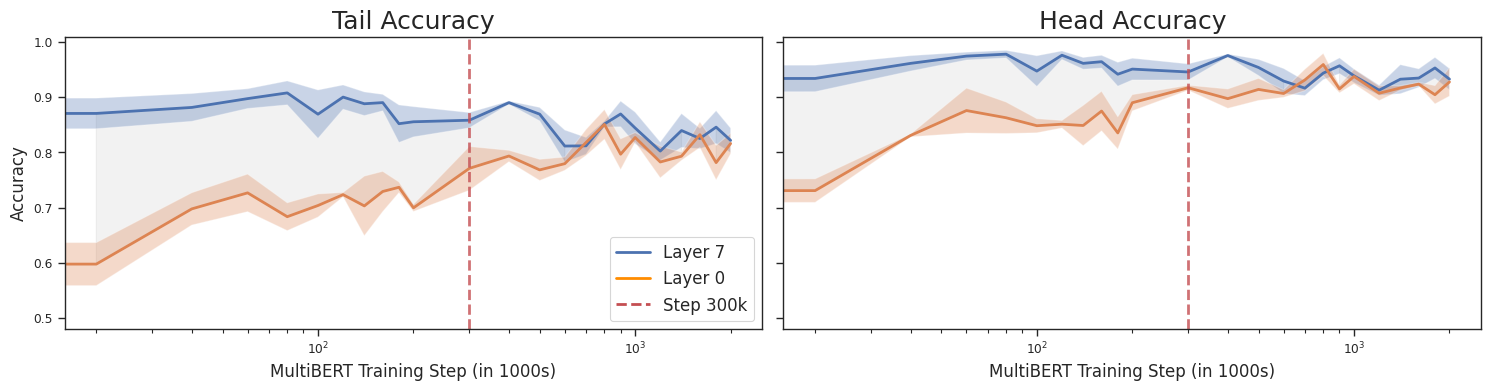

In [231]:
sns.set_theme(context="paper", style="ticks", rc={"lines.linewidth": 2})
head_vs_tail_layer_acc()

In [234]:
from matplotlib.lines import Line2D

steps = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000]
template = '/users/sanand14/data/sanand14/learning_dynamics/outputs/icl_bert/{}/multiberts-{}-step_{}k'

def tail_switch_v_switch_heldout():
    layer_0 = 'layer-0'
    curr_layer = 'layer-7'
    # colors = ['#006D77', '#800020']
    nrows=1
    ncols=2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4 * nrows))
    fig.tight_layout(pad=5.0)
    metrics= ['Tail Switch Accuracy', 'Head Switch Accuracy']
    values_t, values_h = {}, {}
    values_t_err, values_h_err = {}, {}
    for step in steps:
        curr_step = step
        curr_value_t, curr_value_h = [], []
        for seed in ['seed_0', 'seed_1', 'seed_2']:
            curr_dir = template.format(seed, seed, step)
            curr_output_dir = os.path.join(curr_dir, curr_layer)
            curr_value_t += [parse_metric(os.path.join(curr_output_dir, 'val_acc.txt'), 'tail_switch')]
            curr_value_h += [parse_metric(os.path.join(curr_output_dir, 'val_acc.txt'), 'switch')]
            
        values_t[curr_step] = np.mean(curr_value_t)
        values_t_err[curr_step] = np.std(curr_value_t, ddof=1)/np.sqrt(len(curr_value_t))
        values_h[curr_step] = np.mean(curr_value_h)
        values_h_err[curr_step] = np.std(curr_value_h, ddof=1)/np.sqrt(len(curr_value_h))
    
    values_t = np.array([values_t[step] for step in steps])
    values_h =  np.array([values_h[step] for step in steps])
    values_t_err = np.array([values_t_err[step] for step in steps])
    values_h_err = np.array([values_h_err[step] for step in steps])
    
    axes[0].plot(steps, values_t)
    axes[0].plot(steps, values_h)
    axes[0].fill_between(steps, values_t-values_t_err, values_t+values_t_err, alpha=0.3)
    axes[0].fill_between(steps, values_h-values_h_err, values_h+values_h_err, alpha=0.3)
    axes[0].legend(metrics, fontsize=12)
    axes[0].fill_between(steps, values_t, values_h, where=(np.array(values_t) > (np.array(values_h))), color='gray', alpha=0.10)
    axes[0].set_xlabel('MultiBERT Training Step (in 1000s)', fontsize=12)
    axes[0].set_xscale('log')
    axes[0].set_title('Head vs. Tail Switch Accuracy', fontsize=18)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    

    values, values_err= {}, {}
    values_0, values_0_err = {}, {}
    
    for step in steps:
        curr_step = step
        curr_value, curr_value0 = [],[]
        for seed in ['seed_0', 'seed_1', 'seed_2']:
            curr_dir = template.format(seed, seed, step)
            curr_output_dir = os.path.join(curr_dir, curr_layer)
            curr_value += [parse_metric(os.path.join(curr_output_dir, 'val_acc.txt'), 'heldout')]
            curr_value0 += [parse_metric(os.path.join(os.path.join(curr_dir, layer_0), 'val_acc.txt'), 'heldout')]

        values[curr_step] = np.mean(curr_value)
        values_err[curr_step] = np.std(curr_value, ddof=1)/np.sqrt(len(curr_value))
        values_0[curr_step] = np.mean(curr_value0)
        values_0_err[curr_step] = np.std(curr_value0, ddof=1)/np.sqrt(3)
        
    values = np.array([values[step] for step in steps])
    values_0 = np.array([values_0[step] for step in steps])
    values_err = np.array([values_err[step] for step in steps])
    values_0_err = np.array([values_0_err[step] for step in steps])

    axes[1].plot(steps, values)
    axes[1].plot(steps, values_0)
    axes[1].axhline(y=0.5, color='r', linestyle='--', label='Random Baseline')
    axes[1].fill_between(steps, values-values_err, values+values_err, alpha=0.3)
    axes[1].fill_between(steps, values_0-values_0_err, values_0+values_0_err, alpha=0.3)
    axes[1].fill_between(steps, values, [0.5] * len(values), where=(np.array(values) > (np.array([0.5] * len(values)))), color='gray', alpha=0.10)
    # axes[1].set_xscale('log')
    axes[1].set_xlabel('MultiBERT Training Step (in 1000s)', fontsize=12)
    axes[1].legend(['Layer 7', 'Layer 0', 'Random Baseline'], fontsize=12)
    axes[1].set_title('Unseen Token Accuracy', fontsize=18)
    plt.tight_layout()
    

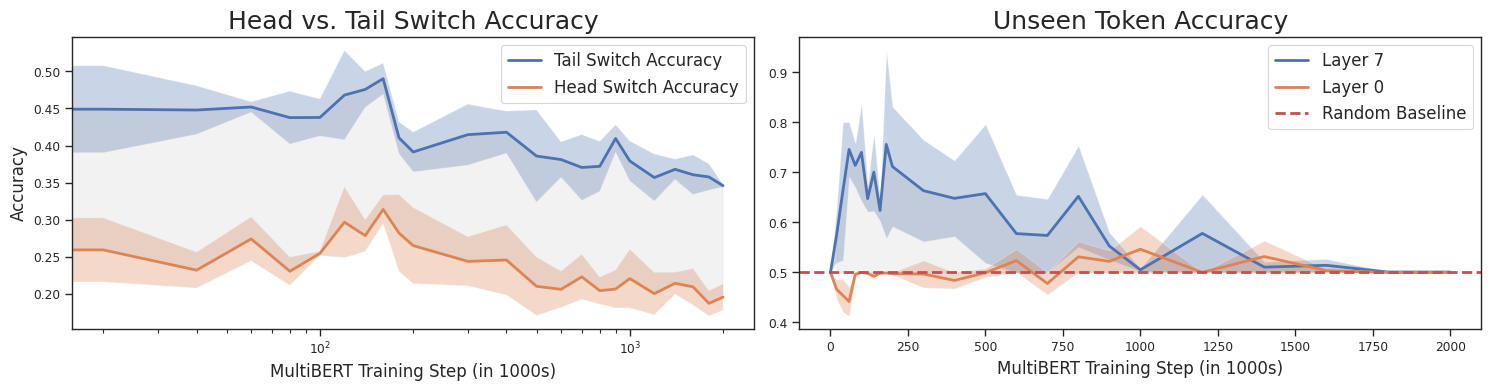

In [235]:
sns.set_theme(context="paper", style="ticks", rc={"lines.linewidth": 2})
tail_switch_v_switch_heldout()

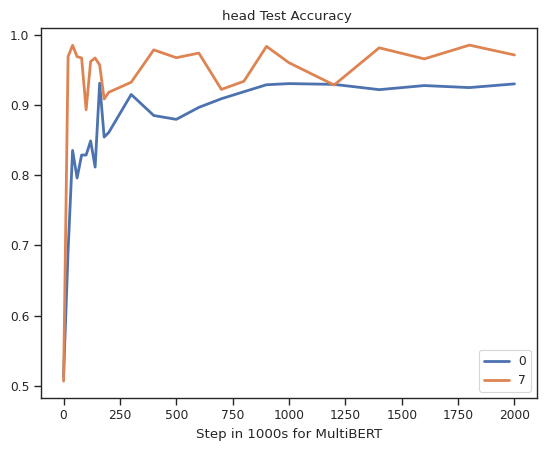

In [150]:
plot_metric([0, 7], 'head', subtract_zero=False)

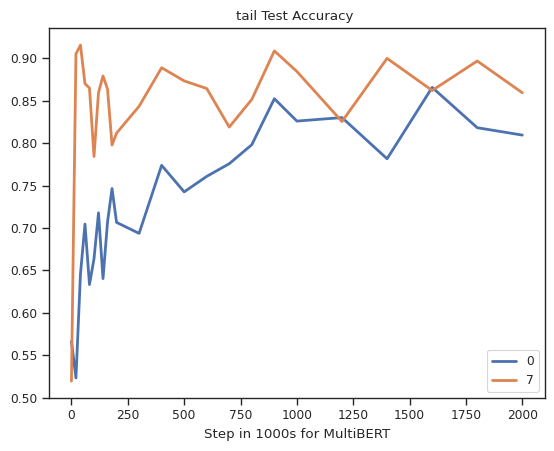

In [151]:
plot_metric([0, 7], 'tail', subtract_zero=False)

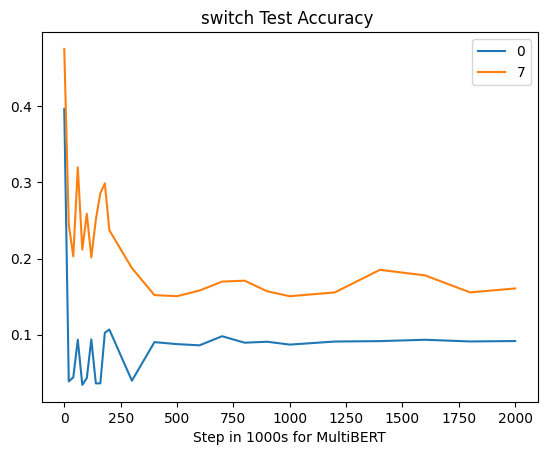

In [169]:
plot_metric([0, 7], 'switch', subtract_zero=False)

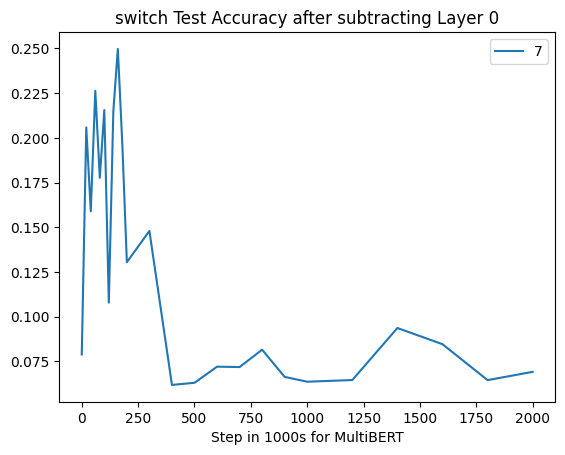

In [172]:
plot_metric(7, 'switch', subtract_zero=True)

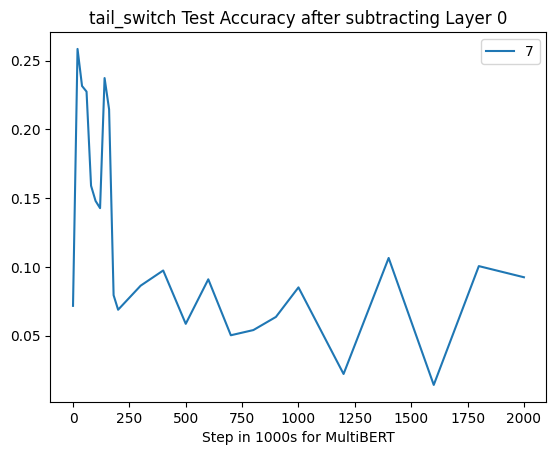

In [173]:
plot_metric(7, 'tail_switch', subtract_zero=True)

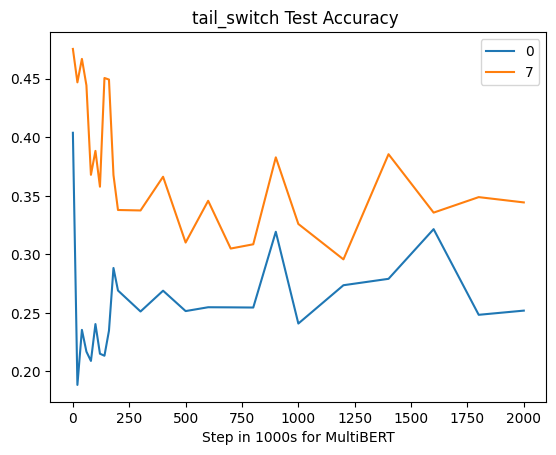

In [170]:
plot_metric([0,  7], 'tail_switch', subtract_zero=False)

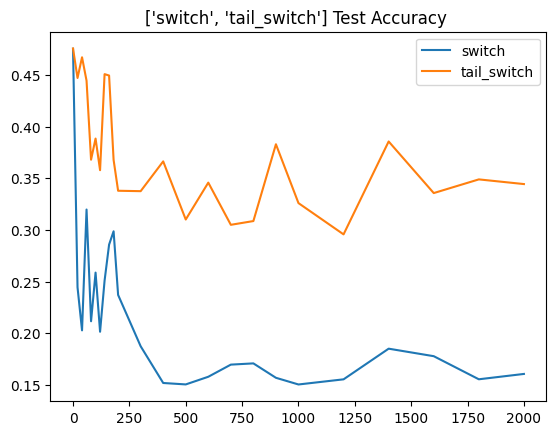

In [164]:
plot_metrics(7, ['switch', 'tail_switch'])

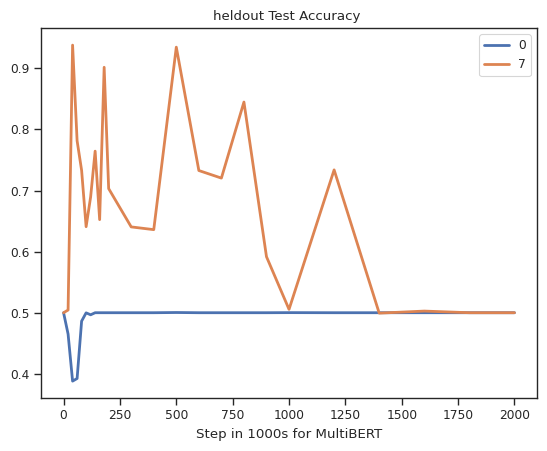

In [192]:
plot_metric([0, 7], 'heldout', subtract_zero=False)

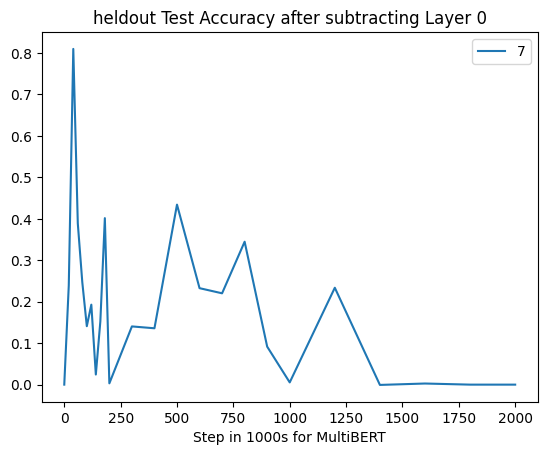

In [38]:
plot_metric([7], 'heldout', subtract_zero=True)

In [106]:
model_name = 'bert-base-uncased'
save_model_name = model_name.split('/')[-1]
model = BertModel.from_pretrained(model_name).to(device)
tokenizer = BertTokenizer.from_pretrained(model_name)

num_nonce_words = 1000

nonce_tokens = [f'thenewtoken{i}' for i in range(num_nonce_words)]
tokenizer.add_tokens(nonce_tokens)
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=16)

Embedding(31536, 768)

In [4]:
data_path = os.path.join(home, "data/ptb_3")
train_data_path = os.path.join(data_path, "ptb3-wsj-train.conllx")
dev_data_path = os.path.join(data_path, "ptb3-wsj-dev.conllx")
test_data_path = os.path.join(data_path, "ptb3-wsj-test.conllx")

In [5]:
train_text = loadText(train_data_path)
dev_text = loadText(dev_data_path)

989860it [00:00, 1142991.82it/s]
41817it [00:00, 1107413.20it/s]


In [6]:
observation_fieldnames = [
    "index",
    "sentence",
    "lemma_sentence",
    "upos_sentence",
    "xpos_sentence",
    "morph",
    "head_indices",
    "governance_relations",
    "secondary_relations",
    "extra_info",
    "embeddings",
]

observation_class = get_observation_class(observation_fieldnames)
train_observations = load_conll_dataset(train_data_path, observation_class)
dev_observations = load_conll_dataset(dev_data_path, observation_class)
task = CPosTask()

In [7]:
@dataclass
class PTBVocab:
    train_ptb : List  = field(default_factory=list)
    test_ptb : List  = field(default_factory=list)
    vocab_size: int = 0
    vocab: Dict[str, Tuple[float, Dict[str, float]]] = field(default_factory=dict)
    nouns: Set[Tuple[str, int]] = field(default_factory=set)
    adjs: Set[Tuple[str, int]] = field(default_factory=set)
    nonce_words : Set[str] = field(default_factory=set)
    
    def __len__(self):
        return self.vocab_size
    
    def __getitem__(self, word):
        return self.vocab.get(word, (0, {}))
    
    def __contains__(self, word):
        return word in self.vocab
    
    def add_word(self, word, pos):
        self.vocab_size += 1
        tuple_word_info = self.vocab.get(word, (0, {}))
        count = tuple_word_info[0] + 1
        pos_dict = tuple_word_info[1]
        pos_dict[pos] = pos_dict.get(pos, 0) + 1
        self.vocab[word] = (count, pos_dict)
    
    def populate_pos_categories(self, proportion_pos: float = 0.8):
        for word, (count, pos_dict) in self.vocab.items():
            if pos_dict.get('NOUN', 0)/count > proportion_pos:
                self.nouns.add((word, count))
            if pos_dict.get('ADJ', 0)/count > proportion_pos:
                self.adjs.add((word, count))
                
    def _get_n(self, n: Union[int, float], sorted_set : List[Tuple[str, int]]):
        assert n > 0, "n must be a positive proportion or integer"
        if n < 1:
            return tuple(zip(*sorted_set[:n*len(sorted_set)]))[0]
        else:
            assert n <= len(sorted_set), "n must be less than length set"
            n = int(n)
            return tuple(zip(*sorted_set[:n]))[0]
        
    def get_nouns_tail(self, n : Union[int, float] = 1000):
        assert n > 0, "n must be a positive proportion or integer"
        sorted_nouns = sorted(self.nouns, key=lambda x: x[1])
        return self._get_n(n, sorted_nouns)
    
    def get_nouns_head(self, n : Union[int, float] = 1000):
        assert n > 0, "n must be a positive proportion or integer"
        sorted_nouns = sorted(self.nouns, key=lambda x: x[1], reverse=True)
        return self._get_n(n, sorted_nouns)
    
    def get_adjs_tail(self, n : Union[int, float] = 1000):
        assert n > 0, "n must be a positive proportion or integer"
        sorted_nouns = sorted(self.adjs, key=lambda x: x[1])
        return self._get_n(n, sorted_nouns)
    
    def get_adjs_head(self, n : Union[int, float] = 1000):
        assert n > 0, "n must be a positive proportion or integer"
        sorted_adjs = sorted(self.adjs, key=lambda x: x[1], reverse=True)
        return self._get_n(n, sorted_adjs)

In [8]:
def find_pos_info(input_tuple):
    indices = []
    elements = []

    for index, element in enumerate(input_tuple):
        if element in ('ADJ', 'NOUN'):
            indices.append(index)
            elements.append(element)
            
    return indices, elements

In [10]:
ptb_vocab = PTBVocab(train_observations, dev_observations)
ptb_vocab.nonce_words = nonce_tokens
for observation in tqdm(ptb_vocab.train_ptb, desc="[adding nouns & adjs to vocab]"):
    indices, elements = find_pos_info(observation.upos_sentence)
    for idx, pos in zip(indices, elements):
        ptb_vocab.add_word(observation.sentence[idx], pos)

ptb_vocab.populate_pos_categories()

[adding nouns & adjs to vocab]:   0%|          | 0/39832 [00:00<?, ?it/s]

In [11]:
def plot_hist_pos(type='noun', n = 2000):
    if type == 'noun':
        values, counts = list(zip(*ptb_vocab.nouns))
    else:
        values, counts = list(zip(*ptb_vocab.adjs))
    idx_sort = np.argsort(counts)[::-1][:n]
    values, counts = np.array(values)[idx_sort], np.array(counts)[idx_sort]
    plt.bar(values, counts)
    plt.xticks([]) 
    plt.title(f'Distribution of {type}')

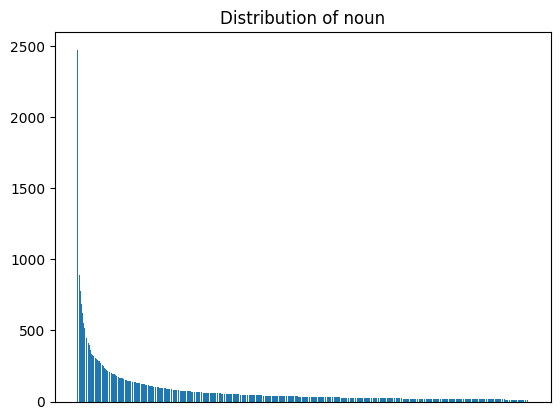

In [12]:
plot_hist_pos('noun')

In [27]:
# 13 * 24 * 4

In [77]:
@dataclass
class ICLBertProbing:
    model: torch.nn.Module
    vocab_gen : PTBVocab
    train_text : List[str]
    train_observations : List
    val_text : List
    val_observations : List[str]
    num_examples_test : int = 10000
    epochs: int = 3
    train_dataloader: DataLoader = None
    test_dataloader: Union[DataLoader, Dict[str, DataLoader], Tuple[DataLoader, ...]] = None
    device: str = "cpu"
    batch_size: int = 128
    nouns: List[int] = None
    adjs: List[int] = None
    
    def create_datasets(self, n=1500):
        tail_nouns = ptb_vocab.get_nouns_tail(n)
        head_nouns = ptb_vocab.get_nouns_head(n)
        tail_adjs = ptb_vocab.get_adjs_tail(n)
        head_adjs = ptb_vocab.get_adjs_head(n)
        
        
        train_text, train_observations = self.train_text, self.train_observations
        val_text, val_observations = self.val_text[:self.num_examples_test], self.val_observations[:self.num_examples_test]
        tail_text, tail_observations = create_dataset(lambda: random.choice(tail_nouns), 
                                                      lambda: random.choice(tail_adjs))
        head_text, head_observations = create_dataset(lambda: random.choice(head_nouns), 
                                                      lambda: random.choice(head_adjs))
        switch_text, switch_observations = create_dataset(lambda: random.choice(head_adjs), 
                                                          lambda: random.choice(head_nouns))
        tail_switch_text, tail_switch_observations = create_dataset(lambda: random.choice(tail_adjs), 
                                                                    lambda: random.choice(tail_nouns))
        nonce_text, nonce_observations = create_dataset(lambda: random.choice(nonce_tokens), 
                                                        lambda: random.choice(nonce_tokens))
        
        self.train_dataloader = self.make_pos_dataloader(train_text, train_observations, shuffle=True)
        self.test_dataloader = {
            'val': self.make_pos_dataloader(val_text, val_observations, shuffle=False), 
            'tail': self.make_pos_dataloader(tail_text, tail_observations, shuffle=False), 
            'head': self.make_pos_dataloader(head_text, head_observations, shuffle=False), 
            'switch': self.make_pos_dataloader(switch_text, switch_observations, shuffle=False), 
            'tail_switch': self.make_pos_dataloader(tail_switch_text, tail_switch_observations, shuffle=False), 
            'heldout': self.make_pos_dataloader(nonce_text, nonce_observations, shuffle=False), 
        }
        
    def create_dataset(self, sample_noun, sample_adj):
        text_dataset = []
        observation_dataset = []
        
        template = 'The {} is {}.'
        upos_format = ['DET', 'NOUN', 'VERB', 'ADJ', 'PUNCT']
        observation_fieldnames_test = [
            "sentence",
            "upos_sentence",
            "embeddings",
        ]
        observation_class_test = get_observation_class(observation_fieldnames_test)
        
        for _ in range(self.num_examples_test):
            curr_noun, curr_adj = sample_noun(), sample_adj()
            curr_sentence = template.format(curr_noun, curr_adj)
            curr_sentence_words = ('The', curr_noun, 'is', curr_adj, '.')
            
            curr_observation = observation_class_test(sentence=curr_sentence_words, upos_sentence=upos_format, embeddings=None)
            text_dataset.append(curr_sentence)
            observation_dataset.append(curr_observation)
        return text_dataset, observation_dataset
    
    # random.choice(tail_nouns), random.choice(tail_adjs)

    def make_pos_dataloader(self, text_dataset, observation_dataset, shuffle=True):
        outer_inputs, outer_labels = defaultdict(list), defaultdict(list)
        dataloaders = {}
        pos_to_label = {
            'NOUN': 0,
            'ADJ': 1,
        }
        model.eval()
        for idx in tqdm(range(len(text_dataset)), desc='[computing pos encodings]'):
            text = "[CLS] " + text_dataset[idx] + " [SEP]"
            observation = observation_dataset[idx]
            
            if 'NOUN' in observation.upos_sentence or 'ADJ' in observation.upos_sentence:
                indices, labels = find_pos_info(observation.upos_sentence)
                labels = [pos_to_label[val] for val in labels]
                
                untokenized_sent = observation.sentence
                tokenized_sent = tokenizer.wordpiece_tokenizer.tokenize(text)
                indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_sent)
                segment_ids = [1 for x in tokenized_sent]

                tokens_tensor = torch.tensor([indexed_tokens]).to(self.device)
                segments_tensors = torch.tensor([segment_ids]).to(self.device)
                with torch.no_grad():
                    encoded_layers = model(tokens_tensor, segments_tensors, output_hidden_states=True)
                encoded_layers = encoded_layers[-1]
                
                untokenized_sent = observation.sentence
                untok_tok_mapping = match_tokenized_to_untokenized(
                    tokenized_sent, untokenized_sent
                )
                for layer in range(len(encoded_layers)):
                    single_layer_features = encoded_layers[layer].squeeze()
                    
                    single_layer_features = torch.stack([
                                torch.mean(
                                    single_layer_features[
                                        untok_tok_mapping[i][0] : untok_tok_mapping[i][-1] + 1, :
                                    ],
                                    axis=0,
                                )
                                for i in indices])
                    outer_inputs[layer].append(single_layer_features)
                    outer_labels[layer].append(labels)
        for layer in outer_inputs.keys():
            outer_inputs[layer] = torch.vstack(outer_inputs[layer]).to(device)
            outer_labels[layer] = torch.tensor(list(itertools.chain(*outer_labels[layer]))).to(device)
            dataset = TensorDataset(outer_inputs[layer].detach(), outer_labels[layer].view(-1, 1).float())
            dataloaders[layer] = DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle, num_workers=0)
        return dataloaders
        
    def conduct_probing(self):
        layer_results = {}
        for layer in self.train_dataloader.keys():
            input_shape = self.train_dataloader[layer].dataset.tensors[0].shape[1]
            probe = Probe(input_shape).to(self.device)
            optimizer = torch.optim.AdamW(probe.parameters(), lr=1e-3)
            train_results = bin_train_loop(probe, self.train_dataloader[layer], self.test_dataloader['val'][layer], optimizer, 3)
            results = {}
            for key, dataloader in self.test_dataloader.items():
                results[key] = bin_val_loop(probe, dataloader[layer])['acc']
            layer_results[layer] = results
        return layer_results

In [70]:
probing = ICLBertProbing(model, ptb_vocab, dev_text, dev_observations, dev_text, dev_observations, device=device)
probing.create_datasets()
layer_results = probing.conduct_probing()

[computing pos encodings]:   0%|          | 0/1700 [00:00<?, ?it/s]

[computing pos encodings]:   0%|          | 0/1000 [00:00<?, ?it/s]

[computing pos encodings]:   0%|          | 0/1000 [00:00<?, ?it/s]

[computing pos encodings]:   0%|          | 0/1000 [00:00<?, ?it/s]

[computing pos encodings]:   0%|          | 0/1000 [00:00<?, ?it/s]

[computing pos encodings]:   0%|          | 0/1000 [00:00<?, ?it/s]

[computing pos encodings]:   0%|          | 0/1000 [00:00<?, ?it/s]

In [75]:
layer_results

{0: {'val': 0.9339923481551968,
  'tail': 0.5925781242549419,
  'head': 0.7417968772351742,
  'switch': 0.20283203106373549,
  'tail_switch': 0.39736328087747097,
  'heldout': 0.5},
 1: {'val': 0.9548560502577801,
  'tail': 0.8480468764901161,
  'head': 0.9446289055049419,
  'switch': 0.24375000037252903,
  'tail_switch': 0.48945312574505806,
  'heldout': 0.5},
 2: {'val': 0.9565643230263068,
  'tail': 0.7288085930049419,
  'head': 0.845703125,
  'switch': 0.26406249962747097,
  'tail_switch': 0.40947265550494194,
  'heldout': 0.5009765625},
 3: {'val': 0.9676339297878499,
  'tail': 0.7390624992549419,
  'head': 0.8685546889901161,
  'switch': 0.29267578199505806,
  'tail_switch': 0.38349609449505806,
  'heldout': 0.6192382834851742},
 4: {'val': 0.963306305359821,
  'tail': 0.7384765632450581,
  'head': 0.8506835959851742,
  'switch': 0.31884765625,
  'tail_switch': 0.39277343824505806,
  'heldout': 0.5},
 5: {'val': 0.9638301754484371,
  'tail': 0.7458007819950581,
  'head': 0.835449